# **EDA: procesamiento y exploración de imágenes**

## **Líbrerias y modulos necesarios**

In [1]:
import os  # Módulo para interactuar con el sistema operativo (gestión de archivos y directorios).

import pandas as pd  # Librería para manipulación y análisis de datos estructurados en DataFrames.
import numpy as np  # Biblioteca para trabajar con arreglos numéricos y operaciones matemáticas eficientes.

import matplotlib.pyplot as plt  # Herramienta para crear gráficos estáticos y visualizaciones.
import seaborn as sns  # Extensión de Matplotlib con estilos mejorados y gráficos estadísticos.

import cv2  # OpenCV, usado para procesamiento de imágenes y visión por computadora.

import re
from glob import glob

import warnings
warnings.filterwarnings('ignore')

## **Contextualización de los datos**


El cáncer de mama es una de las principales causas de mortalidad en mujeres a nivel mundial, y su detección temprana es clave para reducir el número de muertes prematuras. En este contexto, las imágenes de ultrasonido se han convertido en una herramienta fundamental para el diagnóstico, ya que permiten identificar anomalías en el tejido mamario sin procedimientos invasivos.  

El conjunto de datos utilizado en este estudio está compuesto por **imágenes de ultrasonido de mama** clasificadas en **tres categorías**: **tejido normal, tumores benignos y tumores malignos**. Estas imágenes pueden ser utilizadas en tareas de **clasificación, detección y segmentación**, y han demostrado ser altamente efectivas cuando se combinan con técnicas de aprendizaje automático.  

Este conjunto de datos fue recopilado en **2018** e incluye **780 imágenes** en formato **PNG** con un tamaño medio de **500x500 píxeles**, provenientes de **600 pacientes** con edades entre **25 y 75 años**. Además, se cuenta con **máscaras de segmentación** que acompañan las imágenes originales, facilitando estudios avanzados de detección de tumores.  

Al-Dhabyani W, Gomaa M, Khaled H, Fahmy A. *Breast ultrasound images dataset*. Data in Brief, February 2020; 28:104863. DOI: [10.1016/j.dib.2019.104863](https://doi.org/10.1016/j.dib.2019.104863).

<div style="text-align: center;">
    <img src="https://github.com/kmarcela11/ProyectoFinal_DeepLearning/blob/main/Imagen.jpg?raw=true" alt= " " width="600"/>
</div>


## **Conjunto de datos (imágenes)**

Primero, se cargan las imágenes que conforman el conjunto de datos, las cuales están previamente clasificadas en tres categorías según el tipo de tumor: **benigno, normal y maligno**.

In [2]:
# Ruta principal donde están las imagenes
base_path = r'C:\Users\kamac\OneDrive\Desktop\DeepLearningUN\imagenes'

# Definir las categorías (nombre de las carpetas)
categorias = ['benigno', 'normal', 'maligno']

### **Visualización inicial de imágenes**

Antes de visualizar las imágenes se crea la función `extraer_numero(nombre_archivo)`, que emplea expresiones regulares para identificar y extraer el primer número que aparece en el nombre de un archivo. Si se encuentra un número, la función lo convierte en un valor entero; de lo contrario, devuelve un valor infinito (`∞`). Esta técnica resulta clave para ordenar los archivos que contienen números en sus nombres de forma correcta. Los archivos sin números se posicionan al final del orden, lo que garantiza que el proceso de visualización se realice en el orden adecuado. Esta solución es esencial, ya que, sin ella, el código muestra las imágenes en un orden desordenado, lo que dificultaba su análisis. 

In [3]:
# Función para extraer números de los nombres de archivo y ordenarlos correctamente
def extraer_numero(nombre_archivo):
    coincidencia = re.search(r'\d+', nombre_archivo)
    return int(coincidencia.group()) if coincidencia else float('inf')

El siguiente proceso se lleva a cabo para visualizar las primeras imágenes de cada carpeta correspondiente a los tipos de tumor, con el objetivo de analizar en detalle el estado original de las imágenes, sus canales de color, dimensiones y otros aspectos importantes.

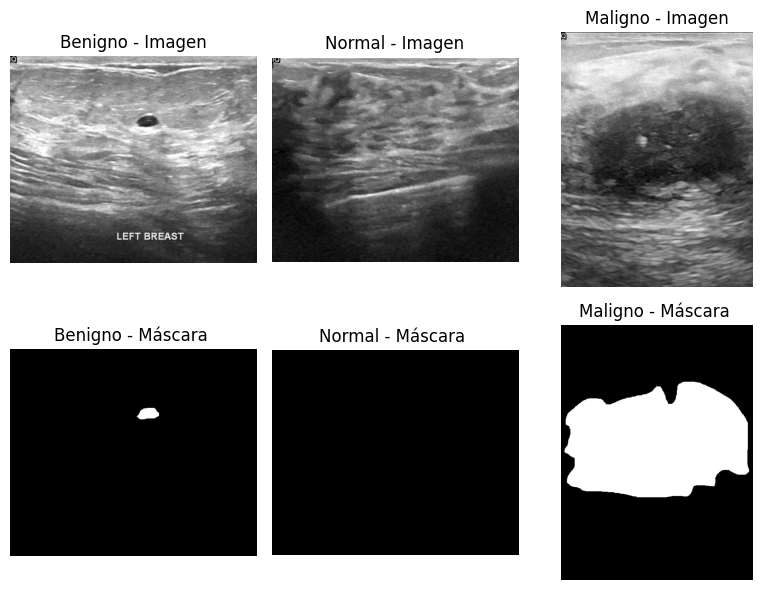

In [4]:
fig, axes = plt.subplots(2, len(categorias), figsize = (8, 6))

for i, categoria in enumerate(categorias): # Itera sobre cada categoría
    ruta_categoria = os.path.join(base_path, categoria) # Ruta de la categoría actual
    imagenes = glob(os.path.join(ruta_categoria, "*.png"))  # Obtener todas las imágenes de esa categoría

    # Filtrar solo las imágenes principales (excluir máscaras)
    archivos_imagenes = [img for img in imagenes if "_mask" not in img] 

    # Ordenar por número extraído del nombre del archivo
    archivos_imagenes = sorted(archivos_imagenes, key = extraer_numero)[:1]

    if not archivos_imagenes: # Validar si no hay imágenes en la categoría
        print(f"No se encontraron imágenes en {categoria}")
        continue

    ruta_imagen = archivos_imagenes[0]  # La ruta del archivo de la primera imagen
    # Cargar la imagen usando OpenCV y convertirla en un formato procesable (un arreglo de píxeles)
    imagen = cv2.imread(ruta_imagen)  

    # Obtener el nombre base de la imagen sin su extensión ".png"
    base_nombre = os.path.splitext(ruta_imagen)[0]  # Remueve la extensión ".png" para obtener solo el nombre base

    # Buscar todas las máscaras asociadas a la imagen. Las máscaras tienen "_mask" en el nombre y terminan en ".png"
    mascaras = sorted(glob(base_nombre + "_mask*.png"), key = extraer_numero)  # Filtra las máscaras relacionadas y las ordena por número

    # 'glob(base_nombre + "_mask*.png")' devuelve una lista de archivos que coinciden con el patrón (por ejemplo, 'imagen_10_mask1.png.)
    
    mascara1 = cv2.imread(mascaras[0]) if len(mascaras) > 0 else None # Cargar la primera máscara si existe

    axes[0, i].imshow(imagen)
    axes[0, i].set_title(f"{categoria.capitalize()} - Imagen")
    axes[0, i].axis("off")

    axes[1, i].imshow(mascara1)
    axes[1, i].set_title(f"{categoria.capitalize()} - Máscara ")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()


En la imagen, se presentan las primeras muestras de cada categoría de tumor, incluyendo benigno, normal y maligno, junto con sus respectivas máscaras. Se observa que las imágenes correspondientes a tumores malignos tienen una dimensión y características visuales distintas en comparación con las de tumores benignos y tejido normal.

### **Cantidad de imágenes**

Ahora veamos la cantidad de imágenes con las que contamos sin diferenciar de máscaras.

In [5]:
# Diccionario para almacenar el conteo de imágenes por categoría
conteo_imagenes = {}
total_imagenes = 0

# Contar imágenes en cada categoría
for i in categorias:
    ruta_categoria = os.path.join(base_path, i)
    imagenes = glob(os.path.join(ruta_categoria, "*.png"))  # Obtener todas las imágenes
    conteo_imagenes[i] = len(imagenes)  # Contar todas las imágenes, sin excluir máscaras
    total_imagenes += conteo_imagenes[i]
    
for categoria, cantidad in conteo_imagenes.items():
    print(f"La cantidad de imágenes en la categoría {categoria.capitalize()} es de {cantidad} imágenes")

print(f"\nTotal de imágenes: {total_imagenes}")

La cantidad de imágenes en la categoría Benigno es de 891 imágenes
La cantidad de imágenes en la categoría Normal es de 266 imágenes
La cantidad de imágenes en la categoría Maligno es de 421 imágenes

Total de imágenes: 1578


En este proceso, contamos con un total de 1,578 imágenes, distribuidas de la siguiente manera: 891 corresponden a la categoría de tumor benigno, 266 a tejido normal y 421 a tumor maligno. Siguiendo el ejemplo anterior, donde se visualizaron las primeras imágenes, podríamos suponer inicialmente que cada imagen tiene una máscara asociada. Sin embargo, al analizar la cantidad de imágenes en la clase benigna, notamos que 891 no es un número divisible exactamente entre dos, lo que plantea dos posibilidades: 1) que algunas imágenes no tengan una máscara asociada o 2) que algunas imágenes tengan más de una máscara.  

Este mismo patrón se observa en la categoría de tumores malignos, mientras que en la clase de tejido normal la cantidad de imágenes coincide perfectamente. Tras una investigación más detallada, descubrimos que la razón detrás de esta discrepancia es que algunas imágenes contienen más de un tumor, lo que genera múltiples máscaras. Más adelante, abordaremos cómo manejar esta particularidad en el análisis.

## **Organización de imágenes en un DataFrame**

Ahora vamos a almacenar las imágenes en un DataFrame con el objetivo de facilitar su análisis y procesamiento. Cada imagen será representada en su formato de píxeles y convertida a escala de color RGB para asegurar coherencia en la manipulación de datos. Este DataFrame permitirá realizar exploraciones, transformaciones y futuras aplicaciones en modelos de análisis de imágenes de manera eficiente. En este paso tendremos en cuenta aquellas imágenes que tienen más de una máscara con el objetivo de posteriormente analizar este comportamiento.

In [6]:
# Lista para almacenar la información de las imágenes
datos_imagenes = []

for categoria in categorias:
    ruta_categoria = os.path.join(base_path, categoria)  # Obtener la ruta completa de la categoría
    imagenes = glob(os.path.join(ruta_categoria, "*.png"))  # Obtener todas las imágenes en la carpeta

    # Filtrar solo las imágenes originales, excluyendo las máscaras
    archivos_imagenes = [img for img in imagenes if "_mask" not in img]
    
    # Ordenar las imágenes por el número extraído de su nombre
    archivos_imagenes = sorted(archivos_imagenes, key = extraer_numero)

    for ruta_imagen in archivos_imagenes:
        # Cargar la imagen original en formato BGR y convertirla a RGB
        imagen = cv2.imread(ruta_imagen)
        imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)

        # Obtener las máscaras asociadas
        nombre_base = os.path.splitext(ruta_imagen)[0]  # Remover la extensión ".png"
        mascaras = sorted(glob(nombre_base + "_mask*.png"), key = extraer_numero)

        # Cargar las máscaras en formato BGR y convertirlas a RGB (si existen)
        mascara1 = cv2.imread(mascaras[0]) if len(mascaras) > 0 else None
        mascara1 = cv2.cvtColor(mascara1, cv2.COLOR_BGR2RGB) if mascara1 is not None else None

        mascara2 = cv2.imread(mascaras[1]) if len(mascaras) > 1 else None
        mascara2 = cv2.cvtColor(mascara2, cv2.COLOR_BGR2RGB) if mascara2 is not None else None

        mascara3 = cv2.imread(mascaras[2]) if len(mascaras) > 2 else None
        mascara3 = cv2.cvtColor(mascara3, cv2.COLOR_BGR2RGB) if mascara3 is not None else None
        
        # Obtener las dimensiones de la imagen
        dimensiones = imagen.shape[:3]

        # Almacenar la información en la lista
        datos_imagenes.append({
            'Imagen': imagen,
            'Máscara 1': mascara1,
            'Máscara 2': mascara2,
            'Máscara 3': mascara3,
            'Dimensiones': dimensiones,
            'Etiqueta': categoria  
        })

df = pd.DataFrame(datos_imagenes)


### **Características principales del DataFrame**

Antes de ver las principales características de este conjunto de datos, se define el siguiente método el cual retorna la imágen.

In [20]:
def mostrar_imagen(fila):
    # Extraer la imagen y las máscaras
    imagen = fila["Imagen"]  # Imagen original
    mask1 = fila["Máscara 1"]  # Primera máscara
    mask2 = fila["Máscara 2"]  # Segunda máscara
    mask3 = fila["Máscara 3"]  # Tercera máscara
    
    # Contar cuántas imágenes hay realmente (si Mask1 o Mask2 es None, no se muestra)
    imagenes = [imagen]
    titulos = [f'Imagen original - Tumor {fila["Etiqueta"]}']

    if mask1 is not None:
        imagenes.append(mask1)
        titulos.append("Máscara 1")

    if mask2 is not None:
        imagenes.append(mask2)
        titulos.append("Máscara 2")
    
    if mask3 is not None:
        imagenes.append(mask3)
        titulos.append("Máscara 3")

    # Crear la figura con subplots dinámicos
    fig, axes = plt.subplots(1, len(imagenes), figsize = (5 * len(imagenes), 5))

    # Si solo hay una imagen, hacer que 'axes' sea iterable
    if len(imagenes) == 1:
        axes = [axes]

    # Mostrar cada imagen
    for ax, img, title in zip(axes, imagenes, titulos):
        ax.imshow(img if img is not None else [[0]], cmap="gray" if "Máscara" in title else None)
        ax.set_title(title)
        ax.axis("off")
    
    plt.show()

In [8]:
df.head()

,Imagen,Máscara 1,Máscara 2,Máscara 3,Dimensiones,Etiqueta
0,"[[[7, 7, 7], [2, 2, 2], [4, 4, 4], [7, 7, 7], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",None,None,"(471, 562, 3)",benigno
1,"[[[0, 0, 0], [58, 58, 58], [188, 188, 188], [2...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",None,None,"(473, 557, 3)",benigno
2,"[[[198, 198, 198], [202, 202, 202], [197, 197,...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",None,None,"(471, 558, 3)",benigno
3,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [5, 5, 5], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",None,"(465, 555, 3)",benigno
4,"[[[187, 187, 187], [187, 187, 187], [188, 188,...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",None,None,"(496, 549, 3)",benigno


In [9]:
df.tail()

,Imagen,Máscara 1,Máscara 2,Máscara 3,Dimensiones,Etiqueta
775,"[[[2, 2, 2], [0, 0, 0], [4, 4, 4], [4, 4, 4], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",None,None,"(571, 792, 3)",maligno
776,"[[[17, 17, 17], [204, 204, 204], [201, 201, 20...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",None,None,"(458, 557, 3)",maligno
777,"[[[0, 0, 0], [91, 91, 91], [57, 57, 57], [3, 3...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",None,None,"(664, 617, 3)",maligno
778,"[[[68, 68, 68], [155, 155, 155], [202, 202, 20...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",None,None,"(471, 508, 3)",maligno
779,"[[[1, 1, 1], [7, 7, 7], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",None,None,"(587, 775, 3)",maligno


Nótese que ahora se encuentran las imágenes almacenadas en una estructura más comóda. Como datos relevantes, nótese también que todas las imágenes cuentan con 3 canales de color (RGB)

In [10]:
df.shape

(780, 6)

El conjunto de datos cuenta con 780 observaciones, organizadas en 6 filas. 

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Imagen       780 non-null    object
 1   Máscara 1    780 non-null    object
 2   Máscara 2    17 non-null     object
 3   Máscara 3    1 non-null      object
 4   Dimensiones  780 non-null    object
 5   Etiqueta     780 non-null    object
dtypes: object(6)
memory usage: 36.7+ KB


Se identificó un total de 780 imágenes, de las cuales 763 tienen una única máscara, 17 poseen dos máscaras y 1 imagen cuenta con tres máscaras.  

Este resultado es coherente con lo mencionado anteriormente, donde inicialmente se estimaba un total de 789 imágenes (1578/2 = 789). Sin embargo, observamos una diferencia de 9 imágenes, lo que indica que había 9 máscaras sin una imagen claramente definida.  

Al reorganizar los datos, se evidencia que estas 9 máscaras adicionales (9 × 2 = 18) corresponden exactamente a las 18 observaciones encontradas en las columnas "Máscara 2" y "Máscara 3", lo que confirma la distribución de las máscaras en el conjunto de datos.

Con el siguiente código se puede observar una fila específica del conjunto de datos. Veamos algunos ejemplos.

In [12]:
df.iloc[0]  # Muestra la primera fila

Imagen         [[[7, 7, 7], [2, 2, 2], [4, 4, 4], [7, 7, 7], ...
Máscara 1      [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
Máscara 2                                                   None
Máscara 3                                                   None
Dimensiones                                        (471, 562, 3)
Etiqueta                                                 benigno
Name: 0, dtype: object

Nótese que este es un ejemplo de que se encuentra una sola máscara. A continuación se muestran las imágenes en formato RGB

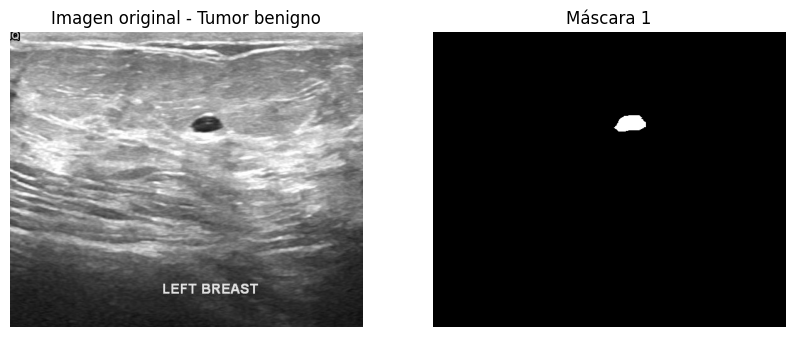

In [21]:
mostrar_imagen(df.iloc[0])

In [14]:
df.iloc[3] # Muestra la cuarta fila

Imagen         [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [5, 5, 5], ...
Máscara 1      [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
Máscara 2      [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
Máscara 3                                                   None
Dimensiones                                        (465, 555, 3)
Etiqueta                                                 benigno
Name: 3, dtype: object

Aquí vemos que en la cuarta fila hay presencia de dos máscaras.

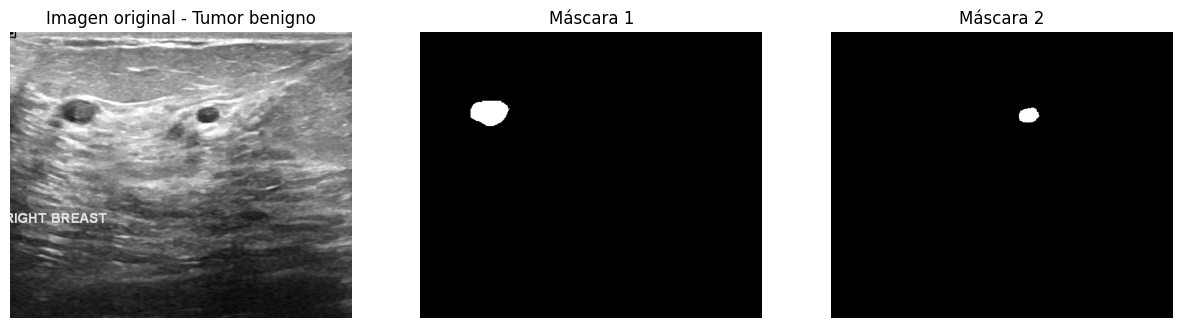

In [22]:
mostrar_imagen(df.iloc[3])

Busquemos ahora cual es la imagen que contiene tres mascaras para posteriormente gráficarlo.

In [24]:
# Filtrar la única observación donde "Máscara 3" no es nula
observacion_mascara3 = df[df["Máscara 3"].notna()]
observacion_mascara3


,Imagen,Máscara 1,Máscara 2,Máscara 3,Dimensiones,Etiqueta
194,"[[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","(611, 729, 3)",benigno


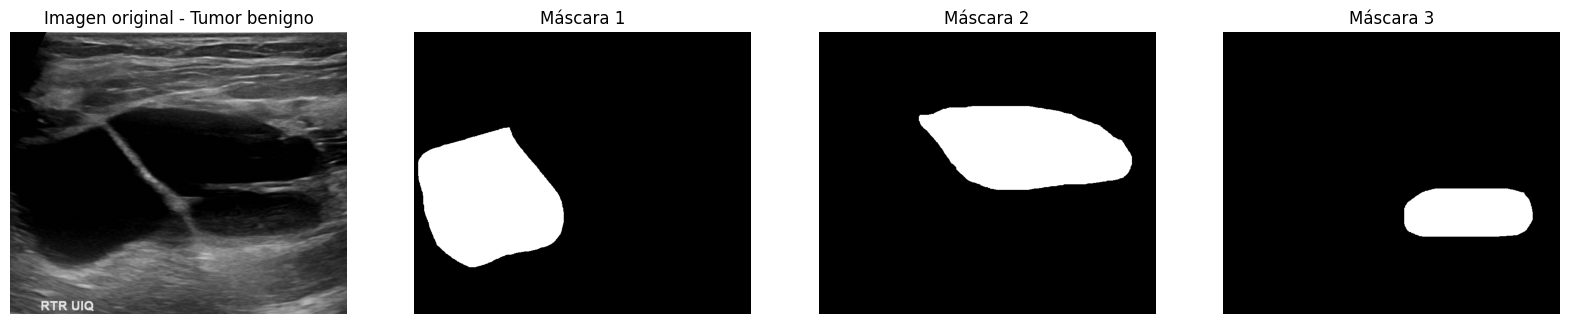

In [26]:
mostrar_imagen(df.iloc[194])

## **Análisis descriptivo**

### **Distribución de clases**

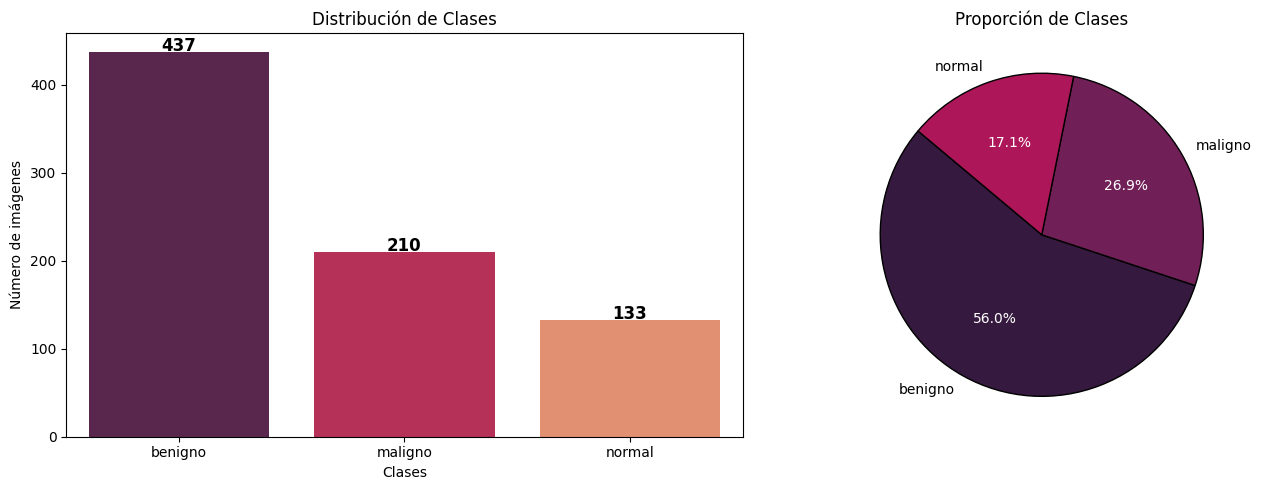

In [50]:

class_counts = df["Etiqueta"].value_counts()
fig, axes = plt.subplots(1, 2, figsize=(14, 5))  

ax = sns.barplot(x = class_counts.index, y = class_counts.values, palette = "rocket", ax = axes[0])

# Agregar valores en las barras
for i, value in enumerate(class_counts.values):
    ax.text(i, value + 1, str(value), ha='center', fontsize = 12, fontweight = 'bold')

axes[0].set_xlabel("Clases")
axes[0].set_ylabel("Número de imágenes")
axes[0].set_title("Distribución de Clases")

axes[1].pie(class_counts, labels = class_counts.index, autopct = '%1.1f%%', colors = sns.color_palette("rocket"), startangle = 140, wedgeprops={'edgecolor': 'black'})
axes[1].set_title("Proporción de Clases")
for text in axes[1].texts:
    if '%' in text.get_text():  # Si es un porcentaje (valor dentro del gráfico)
        text.set_color('white')  
plt.tight_layout()
plt.show()


### **Distribución del tamaño de las imágenes**

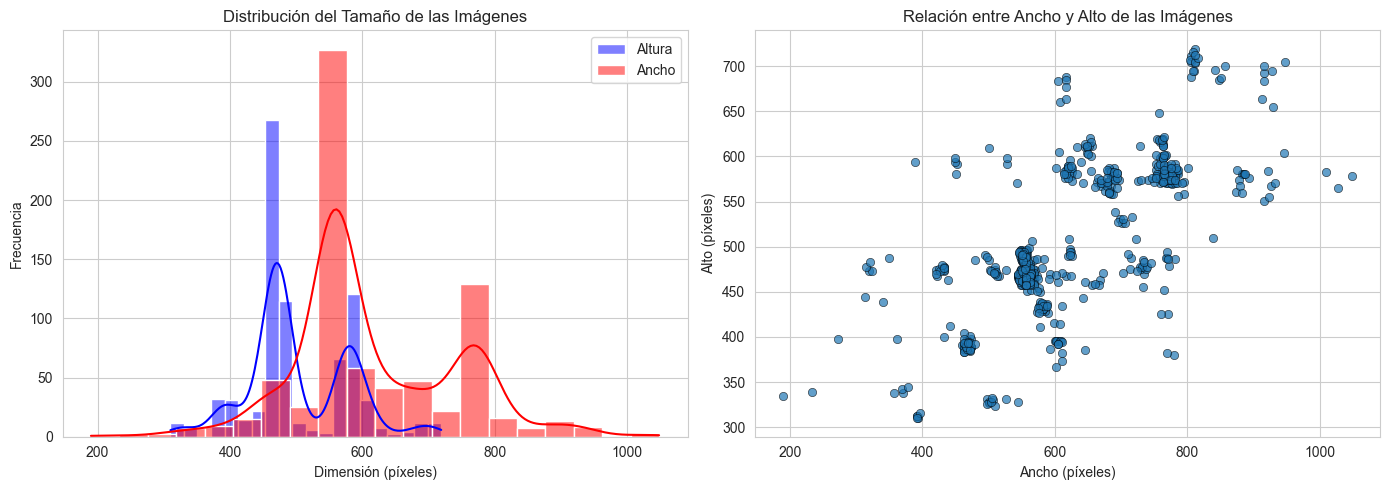

In [ ]:
# Extraer las dimensiones (alto y ancho) de cada imagen en listas separadas
df["Height"] = df["Dimensiones"].apply(lambda x: x[0])  # Alto de la imagen
df["Width"] = df["Dimensiones"].apply(lambda x: x[1])   # Ancho de la imagen

# Crear una figura con 1 fila y 2 columnas
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

## **Histograma de Altura y Ancho**
sns.histplot(df["Height"], bins=20, kde=True, color="blue", ax=axes[0], label="Altura")
sns.histplot(df["Width"], bins=20, kde=True, color="red", ax=axes[0], label="Ancho")

axes[0].set_title("Distribución del Tamaño de las Imágenes")
axes[0].set_xlabel("Dimensión (píxeles)")
axes[0].set_ylabel("Frecuencia")
axes[0].legend()

## **Gráfico de Dispersión: Relación Ancho vs. Alto**
sns.scatterplot(x=df["Width"], y=df["Height"], ax=axes[1], alpha=0.7, edgecolor="black")

axes[1].set_title("Relación entre Ancho y Alto de las Imágenes")
axes[1].set_xlabel("Ancho (píxeles)")
axes[1].set_ylabel("Alto (píxeles)")

# Ajustar el diseño
plt.tight_layout()
plt.show()


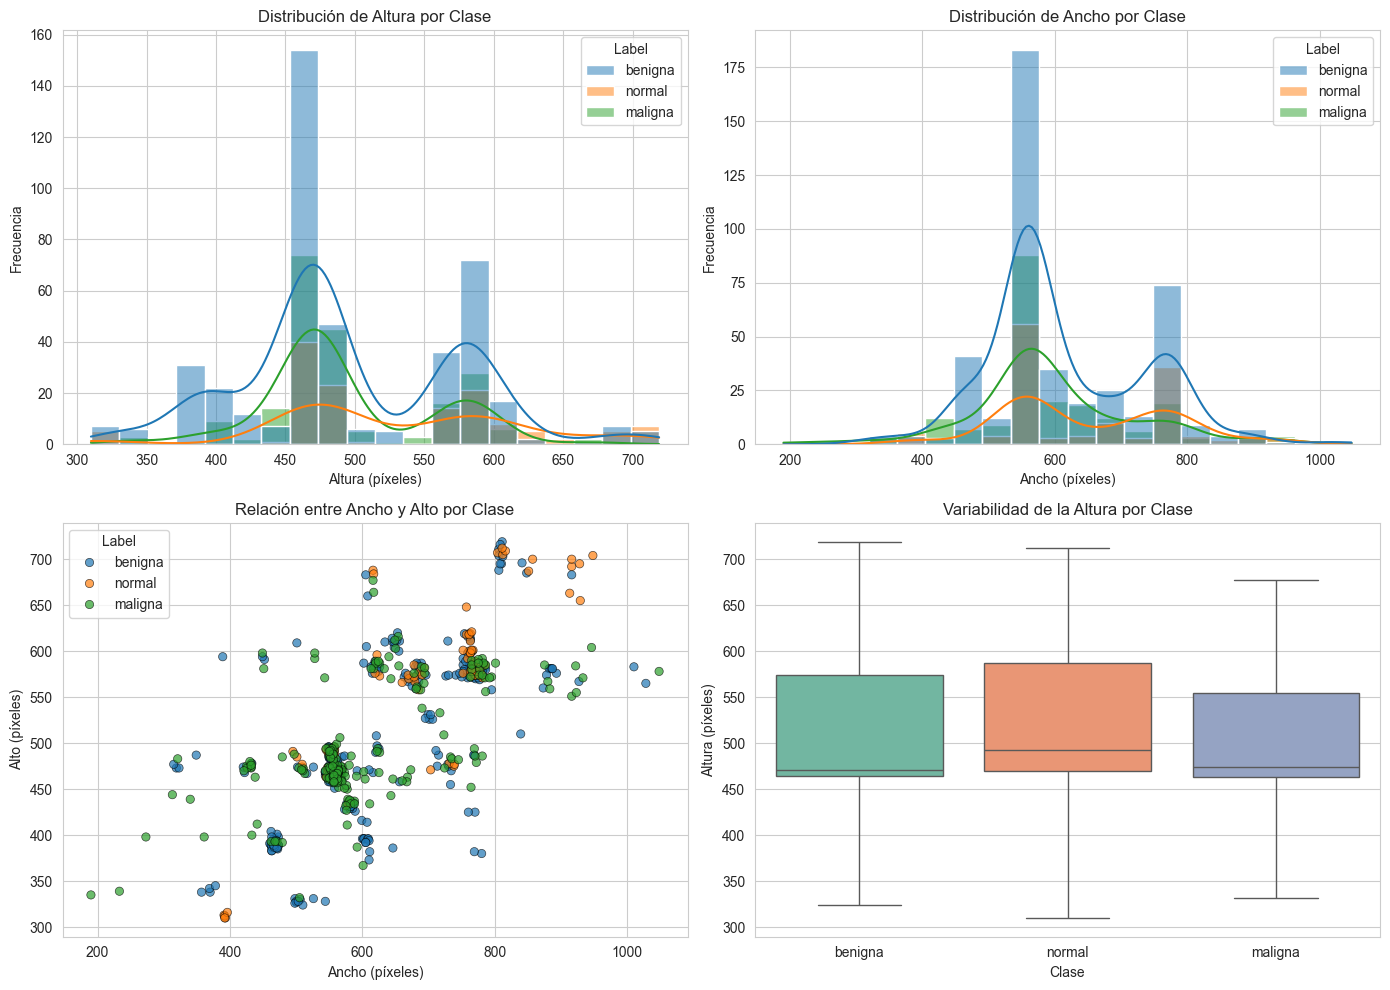

In [ ]:
# Extraer las dimensiones de cada imagen
df["Height"] = df["Dimensiones"].apply(lambda x: x[0])  # Alto
df["Width"] = df["Dimensiones"].apply(lambda x: x[1])   # Ancho

# Definir el tamaño de la figura con 2 filas y 2 columnas
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# **Histograma de Altura por Clase**
sns.histplot(data=df, x="Height", hue="Label", bins=20, kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Distribución de Altura por Clase")
axes[0, 0].set_xlabel("Altura (píxeles)")
axes[0, 0].set_ylabel("Frecuencia")

# **Histograma de Ancho por Clase**
sns.histplot(data=df, x="Width", hue="Label", bins=20, kde=True, ax=axes[0, 1])
axes[0, 1].set_title("Distribución de Ancho por Clase")
axes[0, 1].set_xlabel("Ancho (píxeles)")
axes[0, 1].set_ylabel("Frecuencia")

# **Gráfico de Dispersión: Relación Ancho vs. Alto por Clase**
sns.scatterplot(data=df, x="Width", y="Height", hue="Label", alpha=0.7, edgecolor="black", ax=axes[1, 0])
axes[1, 0].set_title("Relación entre Ancho y Alto por Clase")
axes[1, 0].set_xlabel("Ancho (píxeles)")
axes[1, 0].set_ylabel("Alto (píxeles)")

# **Boxplot para ver la variabilidad del tamaño por clase**
sns.boxplot(data=df, x="Label", y="Height", ax=axes[1, 1], palette="Set2")
axes[1, 1].set_title("Variabilidad de la Altura por Clase")
axes[1, 1].set_xlabel("Clase")
axes[1, 1].set_ylabel("Altura (píxeles)")

# Ajustar el diseño
plt.tight_layout()
plt.show()


### **Distribución de los canales de color**

## **Pre - procesamiento**

### **Redimensión de imágenes**

Redimensionar las imágenes es fundamental en el procesamiento de datos, ya que garantiza que todas tengan un tamaño uniforme, reduce el costo computacional y facilita su uso en modelos de Machine Learning. Al ajustar las dimensiones, se evita el problema de trabajar con imágenes de diferentes tamaños, lo que mejora la eficiencia y compatibilidad con arquitecturas como ResNet o VGG. Además, redimensionarlas ayuda a optimizar el uso de memoria y acelera el entrenamiento sin afectar significativamente la calidad visual.

## **Preparación para modelado**


- Aplicar técnicas de aumento de datos (Data Augmentation).  
- Convertir imágenes a tensores o arrays para modelos de Machine Learning.  